In [1]:
!pip install yfinance

[*********************100%***********************]  2 of 2 completed


Ticker           ADBE       MSFT
Date                            
2012-10-01  32.580002  29.809999
2012-10-02  32.820000  29.680000
2012-10-03  32.730000  29.750000
2012-10-04  32.540001  29.969999
2012-10-05  32.830002  30.230000


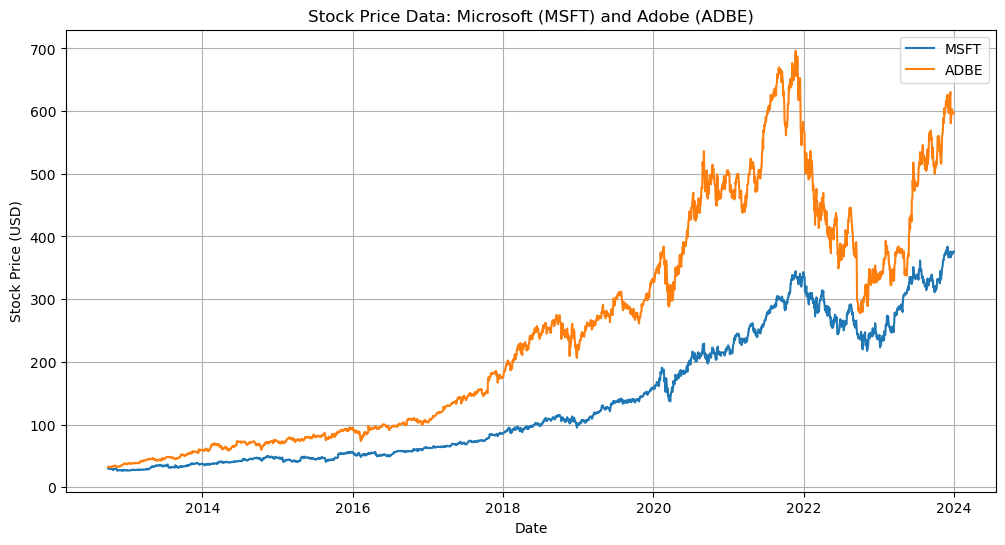

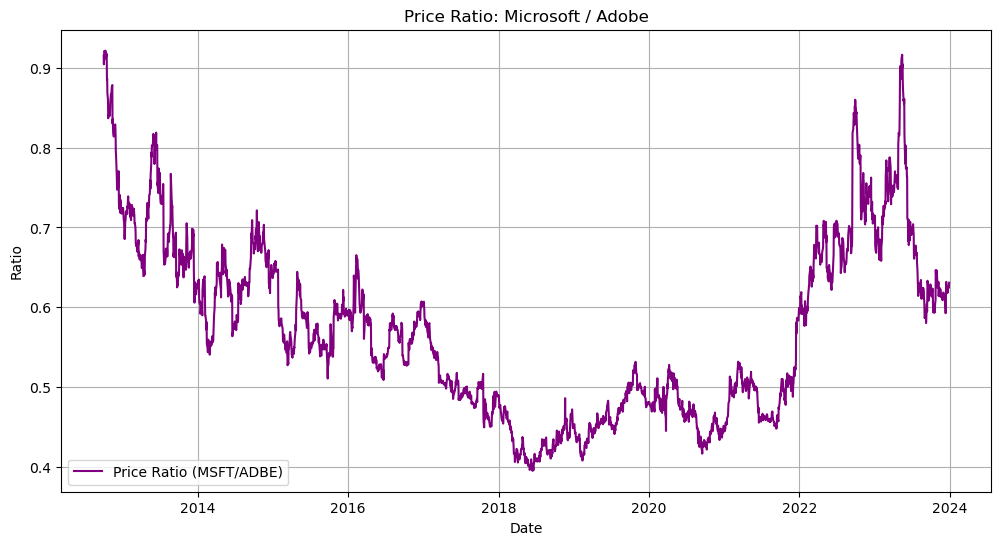

In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
tickers = ['MSFT', 'ADBE']

data = yf.download(tickers, start="2012-10-01", end="2023-12-31")['Open']
print(data.head())
data['Ratio'] = data['MSFT'] / data['ADBE']
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)

plt.title("Stock Price Data: Microsoft (MSFT) and Adobe (ADBE)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['Ratio'], label='Price Ratio (MSFT/ADBE)', color='purple')
plt.title("Price Ratio: Microsoft / Adobe")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.legend()
plt.grid(True)
plt.show()


data.to_csv("stock_prices_msft_adbe2.csv")


In [20]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Ratio'].dropna())  

adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Number of Lags Used": adf_test[2],
    "Number of Observations": adf_test[3]
}
print("ADF Test Results:")
for key, value in adf_result.items():
    print(f"{key}: {value}")


ADF Test Results:
ADF Statistic: -3.3005693599690633
p-value: 0.014853043260625334
Number of Lags Used: 0
Number of Observations: 2829


In [7]:
#Augmented Dickey Fuller test produces a decent <0.05 p-value, so we can assume stationarity of price ratio time series
!pip install pandas_datareader

In [23]:
import pandas_datareader as pdr
from datetime import datetime
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2020, 10, 27), end=datetime(2021, 10, 27)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

ticks = ["DPZ", "AAPL", "GOOG","ADBE", "MSFT"] #Name of company (Dominos pizza)
d = get_historical_Data(ticks)
print(d.shape)
# Most Recent Data
d.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

(252, 5)


,DPZ,AAPL,GOOG,ADBE,MSFT
Date,,,,,
2021-10-20,465.170013,148.699997,144.222504,639.280029,309.209991
2021-10-21,460.649994,148.809998,142.192001,632.000000,307.170013
2021-10-22,467.809998,149.690002,140.350998,640.429993,310.399994
2021-10-25,464.250000,148.679993,138.810501,644.469971,309.359985
2021-10-26,467.519989,149.330002,140.606003,650.909973,311.000000


Ticker            ADBE        MSFT     Ratio     MAVG5    MAVG20    MAVG60  \
Date                                                                         
2023-12-22  600.799988  373.679993  0.621971  0.621561  0.614311  0.617076   
2023-12-26  598.919983  375.000000  0.626127  0.621871  0.615173  0.617033   
2023-12-27  598.599976  373.690002  0.624273  0.622895  0.615575  0.617066   
2023-12-28  597.440002  375.369995  0.628297  0.623703  0.616336  0.617205   
2023-12-29  596.090027  376.000000  0.630777  0.626289  0.617351  0.617495   

Ticker         STD20     STD60  ZScore20_5  ZScore60_5  RateOfChange  
Date                                                                  
2023-12-22  0.010307  0.012812    0.703348    0.350087      0.667903  
2023-12-26  0.010548  0.012777    0.634970    0.378600      0.668253  
2023-12-27  0.010742  0.012793    0.681431    0.455647     -0.296060  
2023-12-28  0.011090  0.012870    0.664322    0.504812      0.644599  
2023-12-29  0.011448  0.012

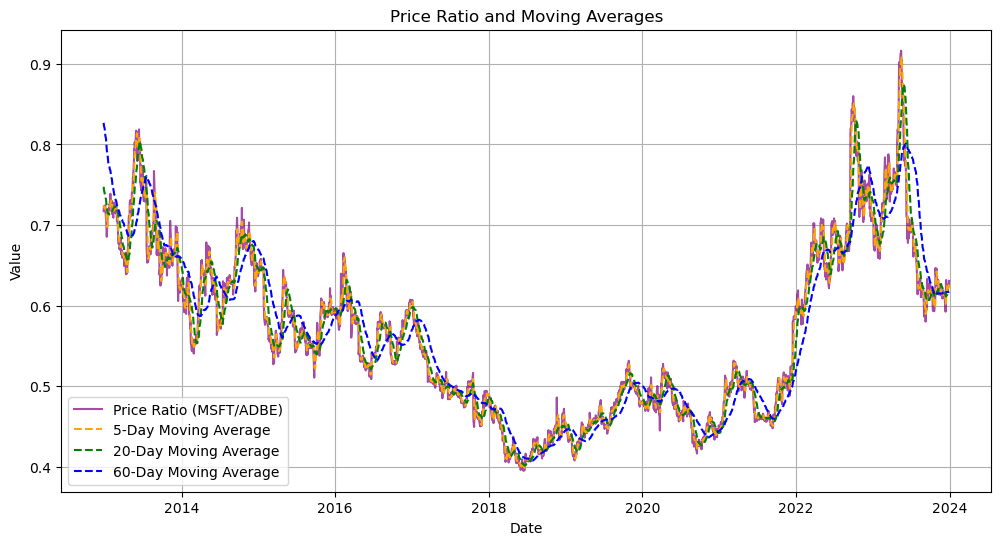

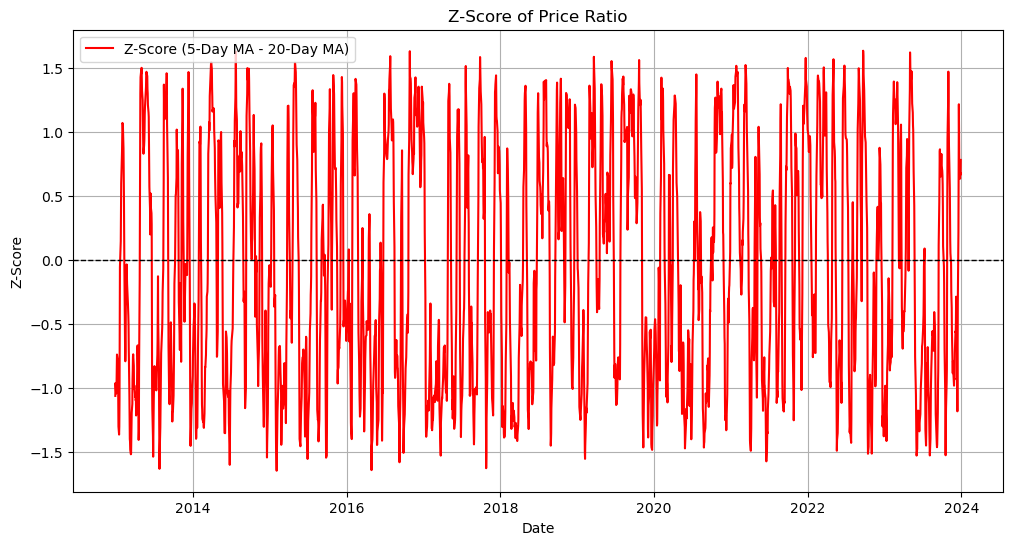

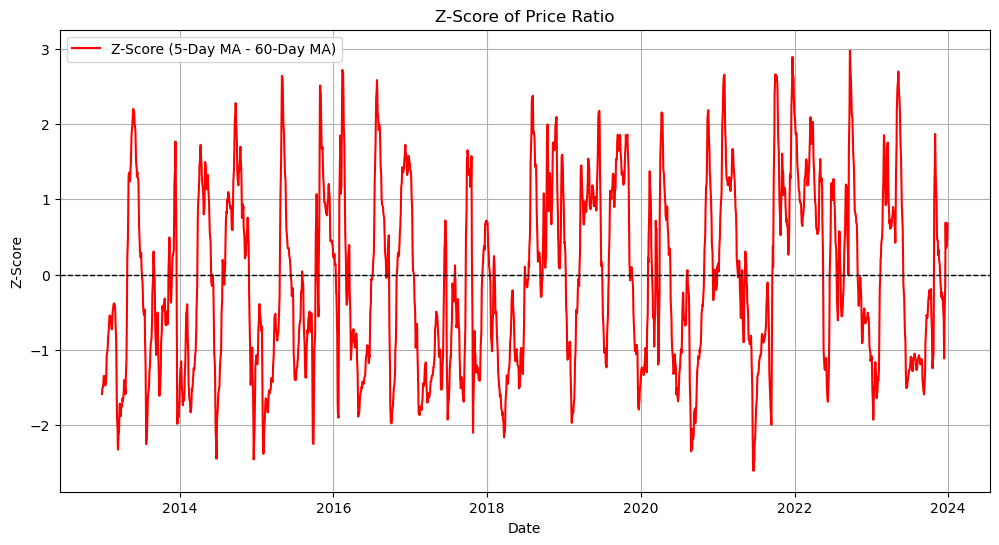

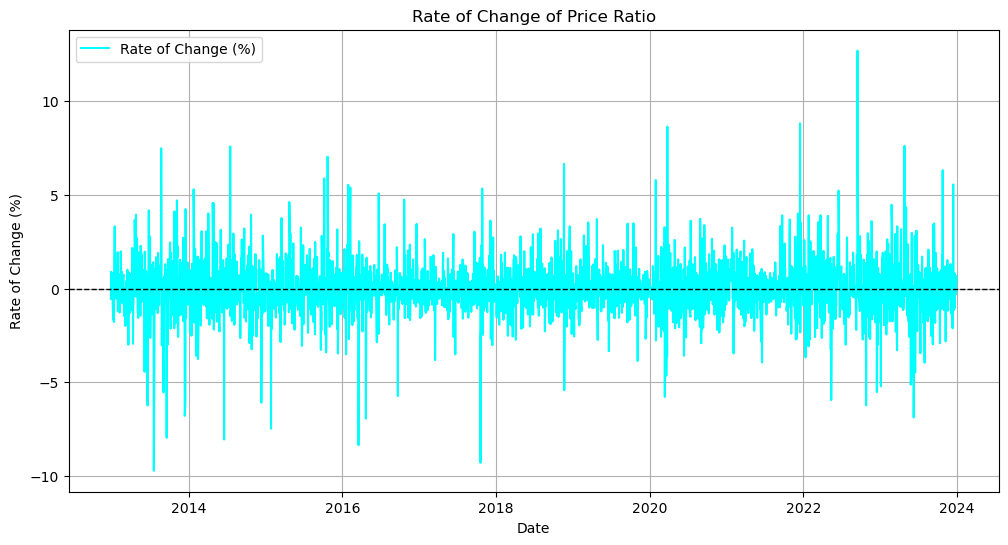

ADF Test Results:
ADF Statistic: -53.7390357925571
p-value: 0.0
Number of Lags Used: 0
Number of Observations: 2770


In [25]:
# Calculate moving averages (5-day, 20-day, and 60-day)
data['MAVG5'] = data['Ratio'].rolling(window=5).mean()
data['MAVG20'] = data['Ratio'].rolling(window=20).mean()
data['MAVG60'] = data['Ratio'].rolling(window=60).mean()

# Calculate the 20-day rolling standard deviation of the ratio
data['STD20'] = data['Ratio'].rolling(window=20).std()
data['STD60'] = data['Ratio'].rolling(window=60).std()

# Calculate the z-score (20-day MA and 5-day MA)
data['ZScore20_5'] = (data['MAVG5'] - data['MAVG20']) / data['STD20']
data['ZScore60_5'] = (data['MAVG5'] - data['MAVG60']) / data['STD60']

# Calculate the rate of change (percentage change over 1 day)
data['RateOfChange'] = data['Ratio'].pct_change() * 100

# Drop rows with NaN values (caused by insufficient data for rolling calculations)
data = data.dropna()

# Display the last few rows of the DataFrame
print(data.tail())

# Plot the ratio and moving averages
plt.figure(figsize=(12, 6))
plt.plot(data['Ratio'], label='Price Ratio (MSFT/ADBE)', color='purple', alpha=0.7)
plt.plot(data['MAVG5'], label='5-Day Moving Average', color='orange', linestyle='--')
plt.plot(data['MAVG20'], label='20-Day Moving Average', color='green', linestyle='--')
plt.plot(data['MAVG60'], label='60-Day Moving Average', color='blue', linestyle='--')
plt.title("Price Ratio and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot the z-score
plt.figure(figsize=(12, 6))
plt.plot(data['ZScore20_5'], label='Z-Score (5-Day MA - 20-Day MA)', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at z-score = 0
plt.title("Z-Score of Price Ratio")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['ZScore60_5'], label='Z-Score (5-Day MA - 60-Day MA)', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at z-score = 0
plt.title("Z-Score of Price Ratio")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

# Plot the rate of change
plt.figure(figsize=(12, 6))
plt.plot(data['RateOfChange'], label='Rate of Change (%)', color='cyan')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at ROC = 0
plt.title("Rate of Change of Price Ratio")
plt.xlabel("Date")
plt.ylabel("Rate of Change (%)")
plt.legend()
plt.grid(True)
plt.show()

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['RateOfChange'].dropna())  

adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Number of Lags Used": adf_test[2],
    "Number of Observations": adf_test[3]
}
print("ADF Test Results:")
for key, value in adf_result.items():
    print(f"{key}: {value}")


RBF Kernel SVM Results:
Mean Squared Error: 0.0004
R-squared: 0.9688
Trend Detection Accuracy: 48.38%

Linear Kernel SVM Results:
Mean Squared Error: 0.0002
R-squared: 0.9814
Trend Detection Accuracy: 49.71%


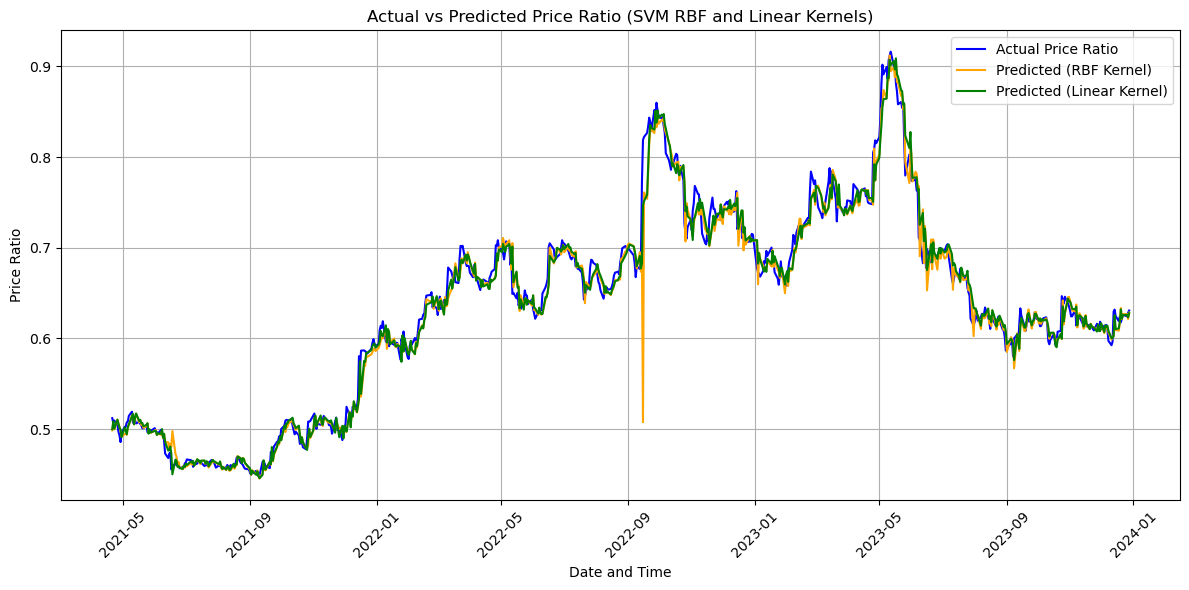

In [27]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering (same as before)
data['MAVG5'] = data['Ratio'].rolling(window=5).mean()
data['MAVG20'] = data['Ratio'].rolling(window=20).mean()
data['MAVG60'] = data['Ratio'].rolling(window=60).mean()
data['STD20'] = data['Ratio'].rolling(window=20).std()
data['ZScore20_5'] = (data['MAVG5'] - data['MAVG20']) / data['STD20']
data['RateOfChange'] = data['Ratio'].pct_change() * 100
data['FutureRatio'] = data['Ratio'].shift(-1)  # Predict the next price ratio

# Drop rows with NaN values
data = data.dropna()

# Define features and target
features = ['MAVG5', 'MAVG20', 'MAVG60', 'STD20', 'ZScore20_5', 'RateOfChange']
X = data[features]
y = data['FutureRatio']

# Split the data into training and testing sets (first 80% for training, last 20% for testing)
train_size = int(len(data) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train and predict using the RBF kernel SVM
svm_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

# Train and predict using the Linear kernel SVM
svm_linear = SVR(kernel='linear', C=100, epsilon=0.01)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

# Evaluate both models
mse_rbf = mean_squared_error(y_test, y_pred_rbf)
r2_rbf = r2_score(y_test, y_pred_rbf)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Calculate trend accuracy for both models
actual_trend = np.sign(y_test.diff().fillna(0))  # +1 for increase, -1 for decrease, 0 for no change
predicted_trend_rbf = np.sign(np.diff([y_test.iloc[0]] + list(y_pred_rbf)))  # Align lengths
predicted_trend_linear = np.sign(np.diff([y_test.iloc[0]] + list(y_pred_linear)))  # Align lengths

trend_accuracy_rbf = np.mean(actual_trend == predicted_trend_rbf) * 100
trend_accuracy_linear = np.mean(actual_trend == predicted_trend_linear) * 100

# Print evaluation metrics for both models
print("RBF Kernel SVM Results:")
print(f"Mean Squared Error: {mse_rbf:.4f}")
print(f"R-squared: {r2_rbf:.4f}")
print(f"Trend Detection Accuracy: {trend_accuracy_rbf:.2f}%")

print("\nLinear Kernel SVM Results:")
print(f"Mean Squared Error: {mse_linear:.4f}")
print(f"R-squared: {r2_linear:.4f}")
print(f"Trend Detection Accuracy: {trend_accuracy_linear:.2f}%")

# Plot predicted vs actual price ratios for both SVM models
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], y_test, label='Actual Price Ratio', color='blue')
plt.plot(data.index[train_size:], y_pred_rbf, label='Predicted (RBF Kernel)', color='orange')
plt.plot(data.index[train_size:], y_pred_linear, label='Predicted (Linear Kernel)', color='green')
plt.xlabel('Date and Time')
plt.ylabel('Price Ratio')
plt.title('Actual vs Predicted Price Ratio (SVM RBF and Linear Kernels)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\shubh\AppData\Local\Temp\ipykernel_12476\3931905324.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['PredictedFutureRatio_RBF'] = y_pred_rbf
C:\Users\shubh\AppData\Local\Temp\ipykernel_12476\3931905324.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['PredictedFutureRatio_Linear'] = y_pred_linear
C:\Users\shubh\AppData\Local\Temp\ipykernel_12476\3931905324.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Ticker      PredictedFutureRatio_RBF  ZScore_pred
Date                                             
2021-05-18                  0.510162     0.786663
2021-05-19                  0.504884     0.752601
2021-05-20                  0.505314     0.591367
2021-05-21                  0.501437     0.167995
2021-05-24                  0.503207     0.101071


ConversionError: Failed to convert value(s) to axis units: '2013-08-15'

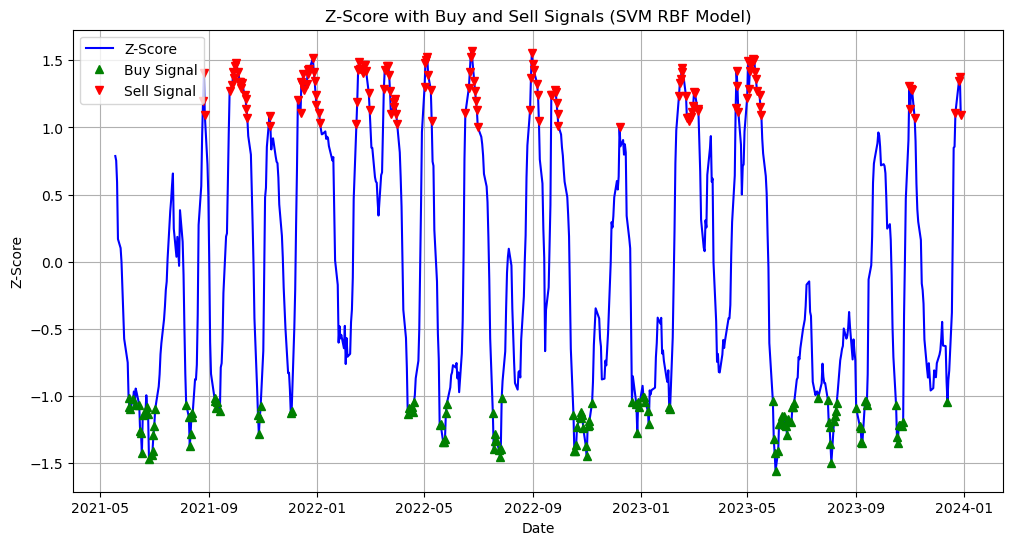

In [29]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# Feature Engineering for the Test Data (Predicted Future Ratio)
# Assuming 'y_pred_rbf' and 'y_pred_linear' are the predicted values from the SVM models
data_test = data.iloc[train_size:]  # Take the test data from the original dataset

# Use the predicted values from both SVM models (RBF and Linear)
data_test['PredictedFutureRatio_RBF'] = y_pred_rbf
data_test['PredictedFutureRatio_Linear'] = y_pred_linear

# Choose the predicted ratio to use (You can use either one or both for comparison)
ratios_pred = data_test['PredictedFutureRatio_RBF']  # Use the predicted future ratio from RBF model

# Calculate moving averages and standard deviation for the predicted ratios
data_test['MAVG5_pred'] = ratios_pred.rolling(window=5).mean()
data_test['MAVG20_pred'] = ratios_pred.rolling(window=20).mean()
data_test['STD20_pred'] = ratios_pred.rolling(window=20).std()

# Calculate the Z-score for the predicted ratios
data_test['ZScore_pred'] = (data_test['MAVG5_pred'] - data_test['MAVG20_pred']) / data_test['STD20_pred']

# Drop rows with NaN values after calculating the rolling statistics
data_test = data_test.dropna()

# Display the new Z-scores for the test data
print(data_test[['PredictedFutureRatio_RBF', 'ZScore_pred']].head())

# Generate buy and sell signals based on the Z-score thresholds
buy_signal = (data_test['ZScore_pred'] < -1).astype(int)  # Buy signal when Z-score is below -1
sell_signal = (data_test['ZScore_pred'] > 1).astype(int)  # Sell signal when Z-score is above 1

# Plot the Z-scores
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['ZScore_pred'], label='Z-Score', color='blue')

# Plot Buy and Sell signals
plt.plot(data_test.index[buy_signal == 1], data_test['ZScore_pred'][buy_signal == 1], 
         marker='^', color='green', linestyle='None', label='Buy Signal')
plt.plot(data_test.index[sell_signal == 1], data_test['ZScore_pred'][sell_signal == 1], 
         marker='v', color='red', linestyle='None', label='Sell Signal')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title('Z-Score with Buy and Sell Signals (SVM RBF Model)')
plt.legend(loc='best')
plt.grid(True)

# Limit the x-axis to a specific range (example: from '2013-08-15' to '2016-07-07')
plt.xlim('2013-08-15', '2016-07-07')

# Show the plot
plt.tight_layout()
plt.show()
